In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
                        #    '--xla_dump_to=xla_dump/')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import arviz as az
import jax
import jax.experimental
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel, UniformTSubspace
from src.jax_test_model import MLPModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree, matrix_to_pytree
import pandas as pd
import wandb
import time
from jax_tqdm import scan_tqdm
from src.utils import get_cp_w, get_data, get_samples_from_run, get_model_from_run_path
from src.jax_subspace_curve import bezier_coeff_fn


%load_ext autoreload
%autoreload 2

%env XLA_FLAGS

#jax.devices("gpu")

'--xla_force_host_platform_device_count=10'

In [2]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### load data

Data shapes: (56, 1) (56,) (33, 1) (33,)


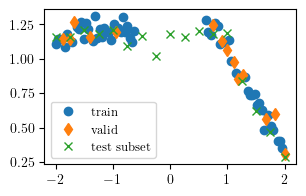

In [3]:
# load data
data = jnp.load('regression_data.npz')
x = jnp.array(data['x'])
y = jnp.array(data['y'])
x_test_ = jnp.array(data['xt'])
y_test_ = jnp.array(data['yt'])
# Split the data into training and validation sets
random_idx = jax.random.choice(random.PRNGKey(
    0), x.shape[0], (int(x.shape[0]*0.2),), replace=False)
x_val = x[random_idx]
y_val = y[random_idx]
x = x[np.setdiff1d(jnp.arange(x.shape[0]), random_idx)]
y = y[np.setdiff1d(jnp.arange(y.shape[0]), random_idx)]

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[
         subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

In [4]:
curve_params = {'k': 5,
                'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'relu'},
                'n_samples': 10,
                'lr': 0.001,
                'num_epochs': 10000,
                'use_validation': False,
                'out_scale': 0.05,
                'optimize_distparams': True
                }

Data shapes: (70, 1) (70,) (33, 1) (33,)


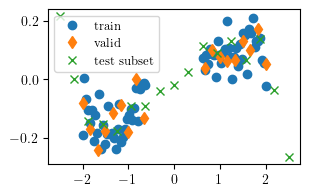

In [5]:
def gen_data(rng_seed, curve_params, **kwargs):
    rng_key = random.PRNGKey(rng_seed + 1133)
    x = jnp.linspace(-2, 2, 100)
    x = x[(jnp.abs(x) > 0.6)].reshape(-1, 1)

    # define ground trouth model
    rng_key, rng_init = random.split(rng_key)
    model_gen = MLPModel(**curve_params['model_kwargs'])
    params = model_gen.init(rng_init, x)

    # generate train data
    y_gt = model_gen.apply(params, x).squeeze()
    rng_key, rng = random.split(rng_key)
    y = y_gt + jax.random.normal(rng, y_gt.shape) * 0.05

    # generate valid data
    x_val = jnp.linspace(-2, 2, 25)
    x_val = x_val[(jnp.abs(x_val) > 0.6)].reshape(-1, 1)
    y_gt_val = model_gen.apply(params, x_val).squeeze()
    rng_key, rng = random.split(rng_key)
    y_val = y_gt_val + jax.random.normal(rng, y_gt_val.shape) * 0.05

    xt = jnp.linspace(-2.5, 2.5, 33).reshape(-1, 1)
    rng_key, rng = random.split(rng_key)
    y_gtt = model_gen.apply(params, xt).squeeze()
    yt = y_gtt + jax.random.normal(rng, y_gtt.shape) * 0.05

    return x, y, x_val, y_val, xt, yt, y_gtt


x, y, x_val, y_val, x_test_, y_test_, _ = gen_data(12, curve_params)

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[
         subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

In [6]:
bezier_coeff_inv = bezier_coeff_fn(curve_params['k'])


def get_d_bezier(t):
    coeff = jax.vmap(bezier_coeff_inv)(t)

    def clousure(cp):
        n = cp.shape[0] - 1
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('tj,j...->t...', coeff, cp_diff) * n
    return clousure


@jit
def bezier_length(cp):
    t = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(t)
    d_t = jnp.linalg.norm(d_bezier(cp), axis=-1)
    length = jax.scipy.integrate.trapezoid(d_t, t)
    return length

### try something out

In [7]:
from src.permutation import initialize_bias, bias_ascending, SubspaceModelPermFree
# define model architecture
model = MLPModel(**curve_params['model_kwargs'])

# define the subspace model to optimize the path
s_model = SubspaceModelPermFree(model,  # any model can be passed
                        k=curve_params['k'],
                        n_samples=curve_params['n_samples'],
                        out_scale=curve_params['out_scale'],
                        optimize_distparams=curve_params['optimize_distparams'])

rng_key = random.PRNGKey(0)
rng_key, init_key = random.split(rng_key)
params = s_model.init_params(init_key, x)

# initialize bias for ascending order
rng_key, init_key = random.split(rng_key)
params = initialize_bias(init_key, params)
# params = bias_ascending(params)

params['params']['Dense_0']['kernel'].shape  # shape (k+1, 3, 16)

(6, 3, 16)

#### train with ascending bias order

In [8]:
# train loop

optimizer = optax.adam(learning_rate=curve_params['lr'])

# dnn_parameters + dist_parameters
opt_state = optimizer.init(params)


def comp_metric_set(x, y):
    return lambda subkey, params: s_model.compute_loss(
        subkey, params, x, y, n_samples=1000)


comp_metric = comp_metric_set(x_val, y_val)
params_store = [params,]*10


@scan_tqdm(curve_params['num_epochs'])
def train(carry, _):
    rng_key, params, opt_state, best_loss, best_params, epoch, epoch_sel, params_store = carry
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(
        subkey, params, x, y, opt_state, optimizer)
    # validate
    rng_key, subkey = random.split(rng_key)
    val_loss = comp_metric(subkey, params)
    best_params, epoch_sel = jax.lax.cond(
        val_loss < best_loss, lambda x: (params, epoch), lambda x: (best_params, epoch_sel), None)
    best_loss = jnp.minimum(best_loss, val_loss)

    cp_w = pytree_to_matrix(params['params'], curve_params['k'])
    length = bezier_length(cp_w)

    # store params

    return (rng_key, params, opt_state, best_loss, best_params, epoch+1, epoch_sel, params_store), (loss, val_loss, length, epoch, cp_w)


carry = (rng_key, params, opt_state, np.inf, params, 0, -1, params_store)
carry, (losses, valid_losses, length, epochs, all_params) = jax.lax.scan(train, carry,
                                                             jnp.arange(curve_params['num_epochs']))

  0%|          | 0/10000 [00:00<?, ?it/s]

(-2.0, -1.0)

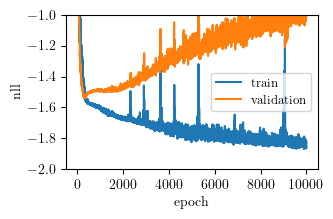

In [9]:
# fast overfitting
plt.plot(losses, label='train')
plt.plot(valid_losses, label='validation')
plt.legend()
plt.ylabel("nll")
plt.xlabel("epoch")
# plt.yscale('log')
plt.ylim(-2, -1.)

(1000, 500)


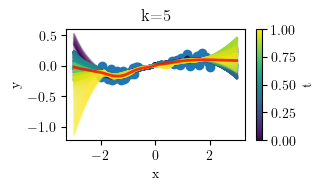

In [10]:
params = carry[4]

# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
print(out.shape)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={curve_params['k']}")
plt.tight_layout()

In [11]:
len(all_params)

10000

(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)


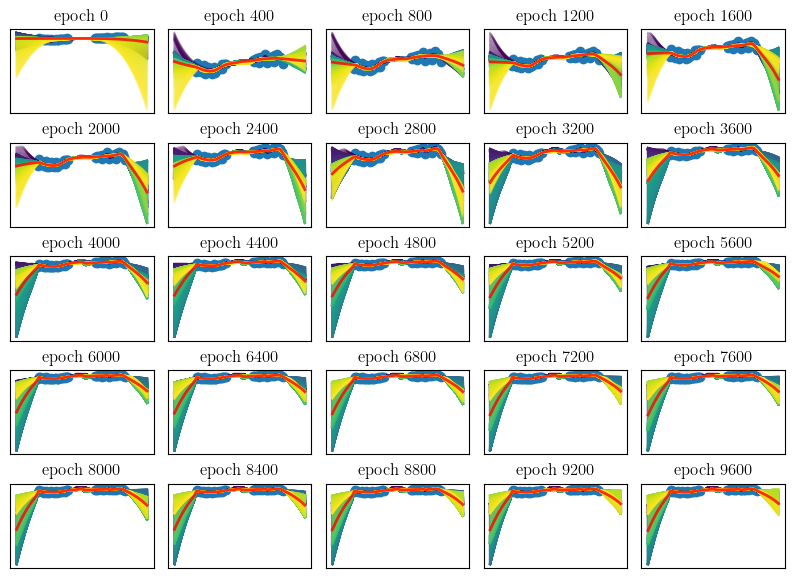

In [12]:
def draw_predictive(ax, cp_w):
    t_space = jnp.linspace(0, 1, 1000)
    x_lin = jnp.linspace(-3, 3, 500)[:, None]
    parma_e = matrix_to_pytree(cp_w, params['params'])
    out = s_model(parma_e, t_space, x_lin).squeeze(axis=-1)
    print(out.shape)
    ax.plot(x, y, 'o', label='train')
    # plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
    # plot lines using viridis color map
    colors = plt.cm.viridis(t_space)
    for o, c in zip(out, colors):
        ax.plot(x_lin, o, color=c, alpha=0.3)
    ax.plot(x_lin, out.mean(axis=0), label='mean',
            c='red', linewidth=2, alpha=0.8)
    # ax.set_ylabel("y")
    # ax.set_xlabel("x")
    # add colorbar
    # sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    #     vmin=t_space.min(), vmax=t_space.max()))
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax)
    # cbar.set_label('t')
    # plt.title(f"k={curve_params['k']}")
    # plt.tight_layout()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig, ax = plt.subplots(5, 5, figsize=(10, 7))
for i, ax_ in enumerate(ax.flatten()):
    draw_predictive(ax_, all_params[i*400])
    ax_.set_title(f"epoch {i*400}")
fig.subplots_adjust(hspace=0.35, wspace=0.1)

In [13]:
carry[6]

Array(312, dtype=int32, weak_type=True)

(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)
(1000, 500)


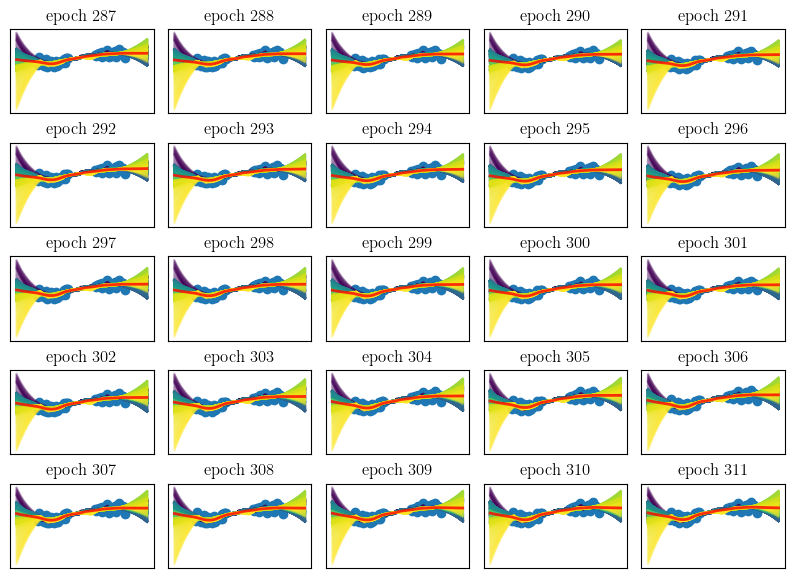

In [14]:

fig, ax = plt.subplots(5, 5, figsize=(10, 7))
for i, ax_ in enumerate(ax.flatten()):
    epoch = i+carry[6]-25
    draw_predictive(ax_, all_params[epoch])
    ax_.set_title(f"epoch {epoch}")
fig.subplots_adjust(hspace=0.35, wspace=0.1)

#### compare span with swa or single 

In [15]:
print("Best validation loss at: ", carry[6])
all_params.shape

Best validation loss at:  312


(10000, 6, 625)

In [16]:
def span(cp, subspace_dim=5):
    mu = cp.mean(0)
    cp -= mu
    u, s, vh = jnp.linalg.svd(cp, full_matrices=False)
    # pi = s[:subspace_dim, None] * vh[:subspace_dim]
    return mu, vh, s, u


mu, vh, s, u = span(all_params[carry[6]])
print("Singular values: \n", s)

Singular values: 
 [7.3399734e+00 7.1918759e+00 7.0897388e+00 6.7828093e+00 6.5721364e+00
 6.1917061e-05]


In [17]:
# span at epoch*+1
mu2, vh2, s2, u2 = span(all_params[carry[6]-25])
jnp.linalg.norm(mu2- mu), s2

(Array(0.12062711, dtype=float32),
 Array([7.3313565e+00, 7.1854868e+00, 7.0762467e+00, 6.7779732e+00,
        6.5639668e+00, 6.1991377e-05], dtype=float32))

In [18]:
# compare the span at epoch* and epoch*+1 with frobenius norm
jnp.linalg.norm(vh - vh2, ord="fro")

Array(0.07139834, dtype=float32)

In [19]:
jnp.linalg.norm(vh, axis=1)

Array([0.99999976, 1.0000008 , 0.9999994 , 0.9999999 , 0.9999997 ,
       1.        ], dtype=float32)

In [20]:
average_cosin_similarity = jnp.dot(vh, vh2.T).diagonal().mean()
average_cosin_similarity = jnp.abs(
    jnp.dot(vh, vh2.T).diagonal())[:-1].mean()
print("Average cosin similarity: ", average_cosin_similarity.item())

Average cosin similarity:  0.9995200037956238


In [21]:
carry[6]

Array(312, dtype=int32, weak_type=True)

In [ ]:
# compare similarity by averaging over the collection

swa_params = all_params[carry[6]-100:carry[6]+2000]

mu_swa, vh_swa, s_swa, u_swa = span(swa_params.mean(0))
print("SWA Singular values: \n", s_swa)
# average cosin similarity with swa (Ignore the last one and axes flips)
average_cosin_similarity = jnp.abs(jnp.dot(vh, vh_swa.T).diagonal())[:-1].mean()
print("Average cosine similarity: ", average_cosin_similarity.item())

SWA Singular values: 
 [7.4989161e+00 7.2528334e+00 7.2061315e+00 6.8182197e+00 6.6673532e+00
 7.9218473e-05]
Average cosin similarity:  0.924787700176239


In [ ]:
# compare similarity with svd computed over all selected parametersparams

mu_swa, vh_swa, s_swa, u_swa = span(swa_params.reshape(-1, swa_params.shape[-1])) # compute span of all params
print("SWPCA Singular values: \n", s_swa[:6])
# average cosin similarity with swa (Ignore the last one and axes flips)
average_cosin_similarity = jnp.abs(
    jnp.dot(vh, vh_swa[:6].T).diagonal())[:-1].mean()
print("Average cosine similarity: ", average_cosin_similarity.item())

PCA SW Singular values: 
 [343.80328  332.466    330.25705  312.5432   305.5912    61.603775]
Average cosin similarity:  0.9233309626579285


#### compare functional diversity along curve with swa against best model selection

In [24]:
# reconstruct error
mat = u_swa[:,:7] @ jnp.diag(s_swa[:7]) @ vh_swa[:7] + mu_swa
jnp.allclose(mat, swa_params.reshape(-1, swa_params.shape[-1]), atol=1e-3)
jnp.linalg.norm(mat - swa_params.reshape(-1, swa_params.shape[-1]), ord="fro")

Array(55.21899, dtype=float32)

(1000, 500)
(1000, 500)


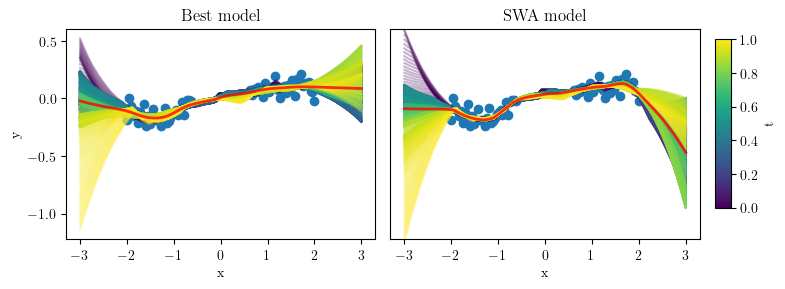

In [25]:
params = carry[4]
# use swa averaged parameters
swa_params_tree = matrix_to_pytree(swa_params.mean(0), params['params'])

# use the first 6 singular values
# swa_params_tree = matrix_to_pytree(u_swa[:6,:6] @ jnp.diag(s_swa[:6]) @ vh_swa[:6] + mu_swa, params['params'])

fig, axes = plt.subplots(1,2, figsize=(8, 3))
# plot predictive for onedimensional regression dataset
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
print(out.shape)
axes[0].plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    axes[0].plot(x_lin, o, color=c, alpha=0.3)
axes[0].plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
axes[0].set_ylabel("y")
axes[0].set_xlabel("x")
axes[0].set_title("Best model")

# plot predictive for onedimensional regression dataset
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(swa_params_tree, t_space, x_lin).squeeze(axis=-1)
print(out.shape)
axes[1].plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    axes[1].plot(x_lin, o, color=c, alpha=0.3)
axes[1].plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
axes[1].set_xlabel("x")
axes[1].get_yaxis().set_visible(False)
axes[1].set_title("SWA model")
axes[1].set_ylim(*axes[0].get_ylim())
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cax = axes[1].inset_axes([1.05, 0.15, 0.05, 0.8])
cbar = fig.colorbar(sm, cax=cax, location='right')
cbar.set_label('t')
plt.tight_layout()

(1000, 500)
(1000, 500)


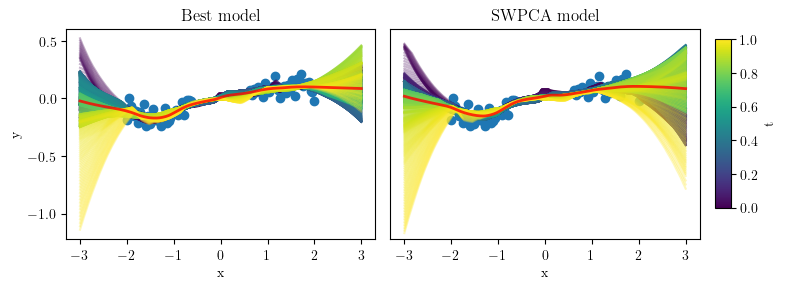

In [35]:
params = carry[4]
# use swa averaged parameters
# swa_params_tree = matrix_to_pytree(swa_params.mean(0), params['params'])

# use the first 6 singular values
swa_params_tree = matrix_to_pytree(
    u_swa[:6, :6] @ jnp.diag(s_swa[:6]) @ vh_swa[:6] + mu_swa, params['params'])

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# plot predictive for onedimensional regression dataset
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
print(out.shape)
axes[0].plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    axes[0].plot(x_lin, o, color=c, alpha=0.3)
axes[0].plot(x_lin, out.mean(axis=0), label='mean',
             c='red', linewidth=2, alpha=0.8)
axes[0].set_ylabel("y")
axes[0].set_xlabel("x")
axes[0].set_title("Best model")

# plot predictive for onedimensional regression dataset
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(swa_params_tree, t_space, x_lin).squeeze(axis=-1)
print(out.shape)
axes[1].plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    axes[1].plot(x_lin, o, color=c, alpha=0.3)
axes[1].plot(x_lin, out.mean(axis=0), label='mean',
             c='red', linewidth=2, alpha=0.8)
axes[1].set_xlabel("x")
axes[1].get_yaxis().set_visible(False)
axes[1].set_title("SWPCA model")
axes[1].set_ylim(*axes[0].get_ylim())
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cax = axes[1].inset_axes([1.05, 0.15, 0.05, 0.8])
cbar = fig.colorbar(sm, cax=cax, location='right')
cbar.set_label('t')
plt.tight_layout()

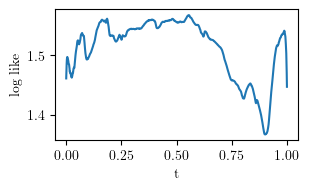

In [27]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 1000)
ll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll)
ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.tight_layout()

In [28]:
cp_w = pytree_to_matrix(params['params'], curve_params['k'])
cp_w.shape

(6, 625)

In [29]:
cp_w = pytree_to_matrix(params['params'], curve_params['k'])
params_restore = matrix_to_pytree(cp_w, params['params'])
jax.tree.all(jax.tree.map(jnp.allclose, params_restore, params['params']))

True

In [30]:
params = bias_ascending(params)
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params['params'], curve_params['k'])
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

Control points in phi space: (6, 5)


In [31]:
curve, d_curve = bezier_curve(curve_params['k']+1, cp_w)
t = jnp.linspace(0, 1, 1000)


def get_bias(t, layer):
    pt = vec_to_pytree(curve(t), params['params'])
    return pt[layer]['bias']


biases = []
for layer in params['params'].keys():
    bias = jax.vmap(get_bias, in_axes=(0, None))(t, layer)
    biases.append(bias)

biases[0].shape

(1000, 16)

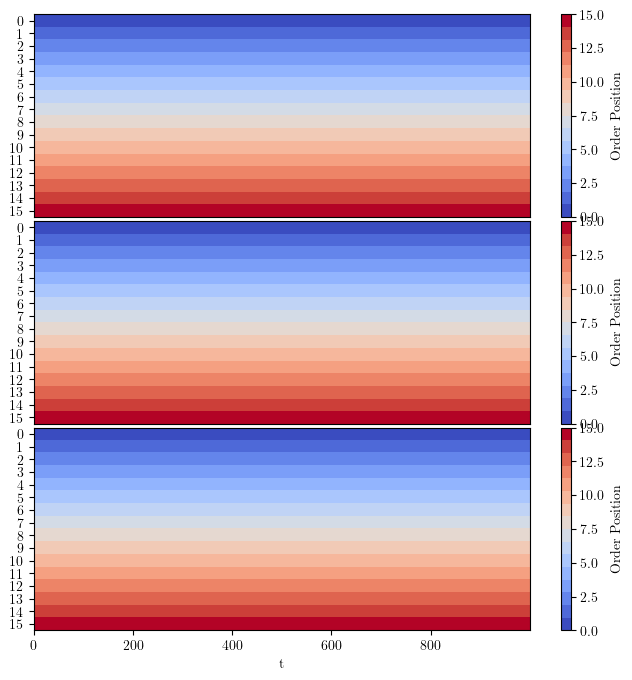

In [32]:
from matplotlib.colors import ListedColormap, BoundaryNorm
# Select SV
def get_sorted_orderings(biases, layer):
    sv_data = biases[layer]  # Shape: (Layer, Epochs, nrUnits)

    # Step 1: Compute the order of the parameters for all epochs
    orderings = np.argsort(sv_data, axis=1)  # Shape: (Epochs, nrUnits)
    # Compute the average order for each parameter
    average_order = np.mean(orderings, axis=0)
    # Sort the parameters based on the average order
    sorted_indices = np.argsort(average_order)
    return orderings[:, sorted_indices].T, sorted_indices


fig, axes = plt.subplots(3, 1, figsize=(8, 8))

for i, ax in enumerate(axes):
    orderings, sorted_indices = get_sorted_orderings(biases, i)
    num_bias = biases[i].shape[1]

    # Define a discrete colormap with 16 colors representing the order positions
    cmap = ListedColormap(plt.get_cmap('coolwarm', num_bias)
                          (np.arange(num_bias)[sorted_indices])) # reorder colors for correct color mapping
    # cmap = plt.get_cmap('coolwarm', num_bias)

    # Create the heatmap where rows are parameters and columns are epochs
    img = ax.imshow(orderings, aspect='auto',
                    interpolation='nearest', cmap=cmap)

    # Customize the colorbar to represent the order positions
    cbar = plt.colorbar(img, label='Order Position')

    ax.set_yticks(np.arange(num_bias))

axes[-1].set_xlabel('t')
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.subplots_adjust(hspace=0.02)